In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json

# Análisis de tiempo modo DRIVING con trafico vs Transporte publico

### min, max y media por periodo

In [117]:
INPUT_FILE_DRIVING = "C:/Users/vehico/Documents/Thesis/Distance-project/school_by_municipality_with_distances_complete.json"
INPUT_FILE_TRANSIT = "C:/Users/vehico/Documents/Thesis/Distance-project/school_by_municipality_with_distances_transit_complete.json"
POPULATION_FILE = "C:/Users/vehico/Documents/Thesis/Distance-project/Data_Italia/DCIS_POPRES1_12022025124521891.csv"

    
# **1. Caricare il file della popolazione**
df_population = pd.read_csv(POPULATION_FILE, delimiter=",", usecols=["ITTER107", "Territorio", "Value"])

df_population = df_population.rename(columns={"Territorio": "Comune", "Value": "Popolazione"})  # Rinomina colonne
df_population = df_population[["Comune", "Popolazione"]]
df_population["Popolazione"] = pd.to_numeric(df_population["Popolazione"], errors="coerce")
df_population["Comune"] = df_population["Comune"].str.upper()

# Filtrare comuni con più di 40.000 abitanti
comuni_validi = set(df_population[df_population["Popolazione"] < 40000]["Comune"])

# **2. Caricare i dati delle distanze**
with open(INPUT_FILE_DRIVING, "r", encoding="utf-8") as f:
    data_driving = json.load(f)

with open(INPUT_FILE_TRANSIT, "r", encoding="utf-8") as f:
    data_transit = json.load(f)

# **3. Estrarre le informazioni e filtrare per comuni validi**
rows = []

for comune, comune_data in data_driving.items():
    if comune not in comuni_validi:
        continue  # Saltiamo i comuni con meno di 40.000 abitanti
    
    distances_driving = comune_data.get("DISTANCE", {})
    distances_transit = data_transit.get(comune, {}).get("DISTANCE", {})

    for nucleo_id, distances in distances_driving.items():
        for school_category, school_list in comune_data.items():
            if school_category not in ["SCUOLA INFANZIA", "SCUOLA PRIMARIA", "SCUOLA PRIMO GRADO", "ISTITUTO COMPRENSIVO"]:
                continue  # Saltiamo le chiavi che non sono categorie scolastiche
            
            for school in school_list:
                school_coords = f"{school['LAT']},{school['LONG']}"
                
                # Tempo di viaggio - Driving
                tempo_s_driving = distances.get(school_coords, {}).get("tempo_s", None)
                m_driving = distances.get(school_coords, {}).get("distanza_m", None)

                # Tempo di viaggio - Transit
                if school_coords in distances_transit.get(nucleo_id, {}):
                    tempo_s_transit = distances_transit[nucleo_id][school_coords]["tempo_s"]
                    m_driving_t = distances_transit[nucleo_id][school_coords]["distanza_m"]
                else:
                    tempo_s_transit = tempo_s_driving  # Se mancante, prendiamo quello driving
                    m_driving_t = m_driving

                if tempo_s_driving is not None:  # Salviamo solo i dati validi
                    rows.append({
                        "Comune": comune,
                        "Nucleo_ID": nucleo_id,
                        "Categoria_Scuola": school_category,
                        "Tempo_s": tempo_s_driving,
                        "Tempo_s_transit": tempo_s_transit,
                        "Distancia_m_driving": m_driving,
                        "Distancia_m_transit": m_driving_t
                    })

# **4. Creare il DataFrame**
df = pd.DataFrame(rows)
df.head(5)


,Comune,Nucleo_ID,Categoria_Scuola,Tempo_s,Tempo_s_transit,Distancia_m_driving,Distancia_m_transit
0,POZZAGLIA SABINA,5705810001.0,SCUOLA INFANZIA,1214,1669,14463,20373
1,POZZAGLIA SABINA,5705810001.0,SCUOLA PRIMARIA,1278,1780,14376,20745
2,POZZAGLIA SABINA,5705810001.0,SCUOLA PRIMO GRADO,1213,1704,13952,20962
3,POZZAGLIA SABINA,5705810001.0,ISTITUTO COMPRENSIVO,1213,1704,13952,20962
4,POZZAGLIA SABINA,5705810002.0,SCUOLA INFANZIA,1538,1522,17806,17612


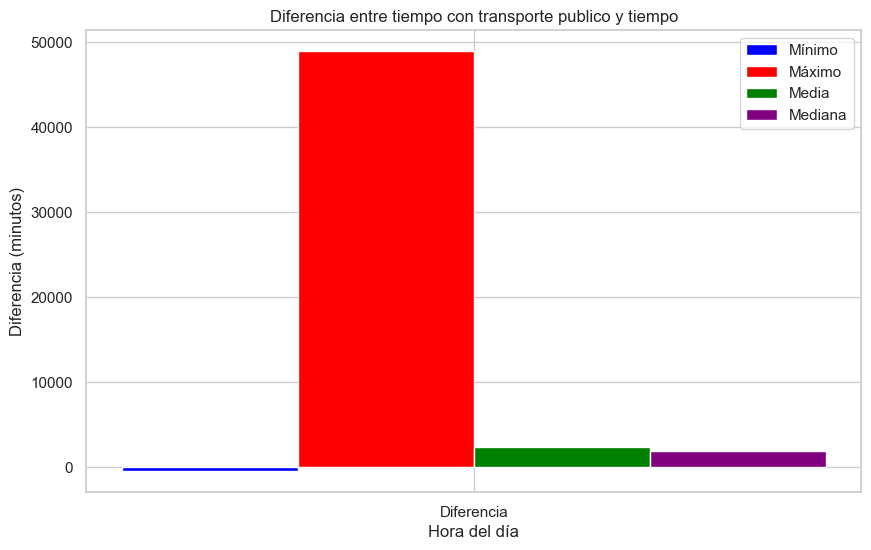

,Min,Max,Media,Mediana,Desviación Estándar,Percentil 25 (Q1),Percentil 75 (Q3),Rango Intercuartílico (IQR)
Diferencia,-495,48949,2388.924859,1850.0,2559.699526,880.0,2919.0,2039.0


In [118]:
# Calcular la diferencia
df['diferencia'] = df['Tempo_s_transit'] - df['Tempo_s']


# Calcular estadísticas (mínimo, máximo, media, mediana, desviación estándar, percentiles)
stats = {
    'Min': df['diferencia'].min(),
    'Max': df['diferencia'].max(),
    'Media': df['diferencia'].mean(),
    'Mediana': df['diferencia'].median(),
    'Desviación Estándar': df['diferencia'].std(),
    'Percentil 25 (Q1)': df['diferencia'].quantile(0.25),
    'Percentil 75 (Q3)': df['diferencia'].quantile(0.75),
    'Rango Intercuartílico (IQR)': df['diferencia'].quantile(0.75) - df['diferencia'].quantile(0.25)
}

stats


# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))

# Datos para las barras
labels = ['Diferencia']
min_values = [stats['Min']]
max_values = [stats['Max']]
mean_values = [stats['Media']]
median_values = [stats['Mediana']]

bar_width = 0.2
x = range(len(labels))

# Graficar las barras
ax.bar(x, min_values, width=bar_width, label='Mínimo', color='blue', align='center')
ax.bar([p + bar_width for p in x], max_values, width=bar_width, label='Máximo', color='red', align='center')
ax.bar([p + bar_width * 2 for p in x], mean_values, width=bar_width, label='Media', color='green', align='center')
ax.bar([p + bar_width * 3 for p in x], median_values, width=bar_width, label='Mediana', color='purple', align='center')

# Personalizar el gráfico
ax.set_xlabel('Hora del día')
ax.set_ylabel('Diferencia (minutos)')
ax.set_title('Diferencia entre tiempo con transporte publico y tiempo')
ax.set_xticks([p + bar_width * 1.5 for p in x])
ax.set_xticklabels(labels)
ax.legend()

plt.show()


# Crear DataFrame con las estadísticas para mostrar en formato tabla
df_stats = pd.DataFrame([stats], index=['Diferencia'])
df_stats


### añadimos nombre de municipios de microservicio

# Diferencia por fila

In [119]:
df.head()

,Comune,Nucleo_ID,Categoria_Scuola,Tempo_s,Tempo_s_transit,Distancia_m_driving,Distancia_m_transit,diferencia
0,POZZAGLIA SABINA,5705810001.0,SCUOLA INFANZIA,1214,1669,14463,20373,455
1,POZZAGLIA SABINA,5705810001.0,SCUOLA PRIMARIA,1278,1780,14376,20745,502
2,POZZAGLIA SABINA,5705810001.0,SCUOLA PRIMO GRADO,1213,1704,13952,20962,491
3,POZZAGLIA SABINA,5705810001.0,ISTITUTO COMPRENSIVO,1213,1704,13952,20962,491
4,POZZAGLIA SABINA,5705810002.0,SCUOLA INFANZIA,1538,1522,17806,17612,-16


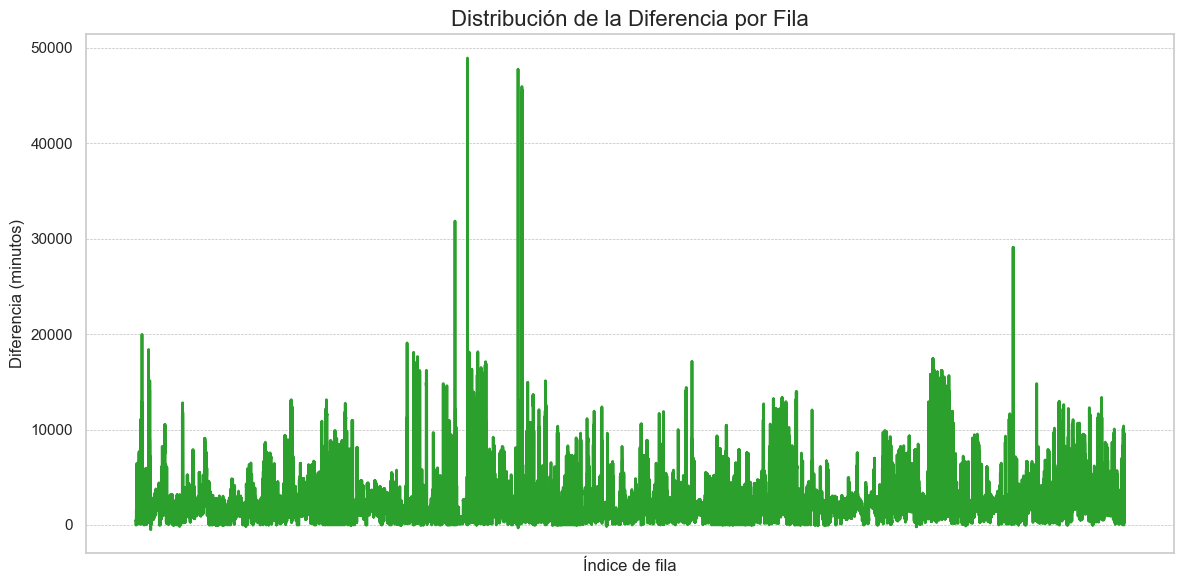

In [120]:
# Crear un gráfico de líneas para la distribución de las diferencias por fila
plt.figure(figsize=(12, 6))

# Gráfico para 9AM con color verde
sns.lineplot(x=df.index, y='diferencia', data=df, color='#2ca02c', linewidth=2)


# Personalizar el gráfico
plt.title('Distribución de la Diferencia por Fila', fontsize=16)
plt.xlabel('Índice de fila', fontsize=12)
plt.ylabel('Diferencia (minutos)', fontsize=12)

# Quitar los nombres del índice en el eje X
plt.xticks([])  # Quita las etiquetas del eje X


# Mejorar la distinción de colores con mayor contraste
plt.grid(axis='y', linestyle='--', alpha=0.5, color='gray', linewidth=0.5)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [135]:
df_outliers = df[df['diferencia'] > 20000]
df_outliers

,Comune,Nucleo_ID,Categoria_Scuola,Tempo_s,Tempo_s_transit,Distancia_m_driving,Distancia_m_transit,diferencia
5280,ASCREA,5700410002.0,SCUOLA PRIMARIA,752,32612,6494,77440,31860
5486,CASAPROTA,5701110001.0,ISTITUTO COMPRENSIVO,1236,50185,14033,83100,48949
6323,MARCETELLI,5703610001.0,SCUOLA PRIMARIA,2284,50071,20556,117869,47787
6386,MONTENERO SABINO,5704210001.0,SCUOLA PRIMO GRADO,1239,47201,13432,79161,45962
6387,MONTENERO SABINO,5704210001.0,ISTITUTO COMPRENSIVO,1239,47201,13432,79161,45962
6390,MONTENERO SABINO,5704220003.0,SCUOLA PRIMO GRADO,1451,46899,15279,76957,45448
6391,MONTENERO SABINO,5704220003.0,ISTITUTO COMPRENSIVO,1451,46899,15279,76957,45448
6394,MONTENERO SABINO,5704226601.0,SCUOLA PRIMO GRADO,1396,46977,14776,77490,45581
6395,MONTENERO SABINO,5704226601.0,ISTITUTO COMPRENSIVO,1396,46977,14776,77490,45581
14511,SANT'ELIA FIUMERAPIDO,6006826602.0,SCUOLA INFANZIA,1315,30419,12554,19917,29104


### ¿Qué municipios tienen los mínimos, máximos y valores prox. a 0?

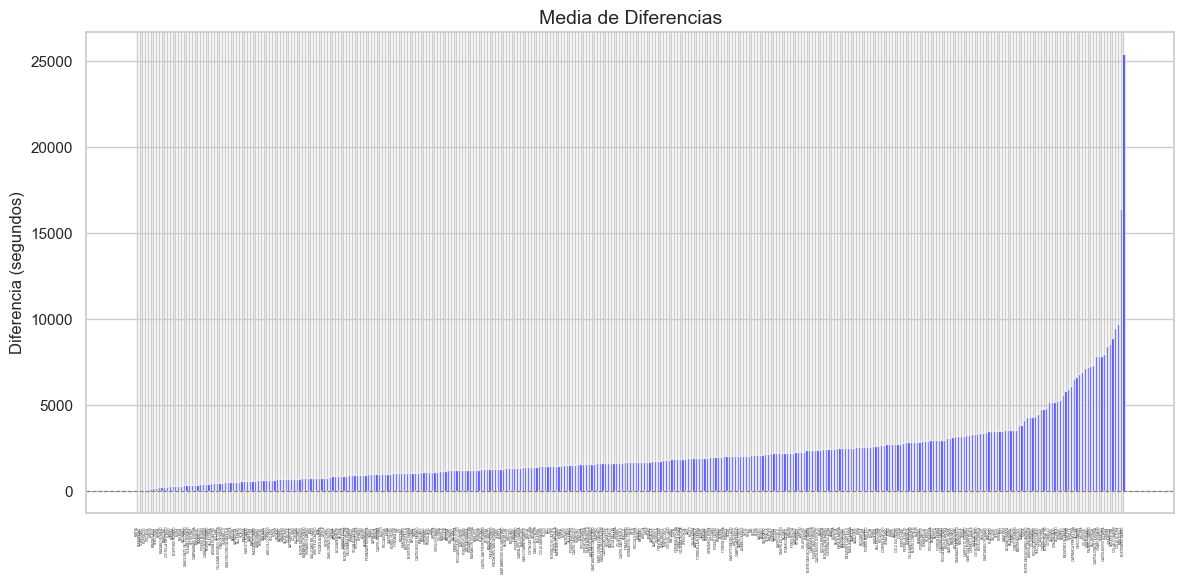

In [121]:
import pandas as pd
import matplotlib.pyplot as plt

# Calcular la media por municipio
mean = df.groupby("Comune")["diferencia"].mean().reset_index()


# Función para plotear con etiquetas encima
def plot_with_labels(df, column, title, color):
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(df)), df[column], color=color, alpha=0.7)

    # Configuración del gráfico
    plt.title(title, fontsize=14)
    plt.ylabel("Diferencia (segundos)", fontsize=12)
    plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    plt.xticks(
        range(len(df)),
        df["Comune"],
        rotation=90,
        fontsize=2,  # Tamaño de fuente más pequeño
    )
    plt.tight_layout()
    plt.show()

# Crear gráficos
plot_with_labels(mean.sort_values("diferencia"), "diferencia", "Media de Diferencias", "blue")

In [ ]:
# Función para obtener los 5 valores más altos, más bajos y más cercanos a cero
def get_top_values(df, col):
    df_sorted_highest = df.nlargest(5, col).copy()
    df_sorted_lowest = df.nsmallest(5, col).copy()
    df_sorted_closest_to_zero = df.iloc[(df[col].abs().argsort()[:5])].copy()
    return df_sorted_highest, df_sorted_lowest, df_sorted_closest_to_zero

# Procesar df_9AM
df_high, df_low, df_zero = get_top_values(df, 'diferencia')



# Crear las tablas combinadas
def create_summary_table(high, low, zero, col_name):
    high['categoria'] = 'Más altos'
    low['categoria'] = 'Más bajos'
    zero['categoria'] = 'Más cercanos a 0'
    combined = pd.concat([high, low, zero])

    # Añadir las columnas de 'tiempo_con_trafico' y 'tiempo' a la tabla combinada
    combined['Tempo_s_transit'] = combined['Tempo_s_transit']
    combined['Tempo_s'] = combined['Tempo_s']

    # Seleccionar las columnas relevantes
    return combined[['Comune', 'Nucleo_ID', col_name, 'categoria', 'Tempo_s_transit', 'Tempo_s']]

# Tablas resumen con las columnas de tiempo
summary = create_summary_table(df_high, df_low, df_zero, 'diferencia')

# Configuración de pandas para que se muestren más columnas sin que se corten
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', 1000)        # Ajustar el ancho de la pantalla
pd.set_option('display.max_rows', None)     # Mostrar todas las filas sin truncar

# Mostrar las tablas
print("Resumen de diferencia:")
print(summary)



Resumen de diferencia_9AM:
                 Comune     Nucleo_ID  diferencia         categoria  Tempo_s_transit  Tempo_s
5486          CASAPROTA  5701110001.0       48949         Más altos            50185     1236
6323         MARCETELLI  5703610001.0       47787         Más altos            50071     2284
6386   MONTENERO SABINO  5704210001.0       45962         Más altos            47201     1239
6387   MONTENERO SABINO  5704210001.0       45962         Más altos            47201     1239
6394   MONTENERO SABINO  5704226601.0       45581         Más altos            46977     1396
248              AFFILE  5800110001.0        -495         Más bajos              665     1160
6325         MARCETELLI  5703610001.0        -314         Más bajos             2403     2717
12910         FILETTINO  6003410001.0        -194         Más bajos             1049     1243
12912         FILETTINO  6003410001.0        -194         Más bajos             1049     1243
724           CANTERANO  58017100

### Diferencia por municipio (media)

podemos añadir que tipo de centros educativos agrupan menos diferencia etc


               Comune  media_diferencia  categoria
178             MARTA         -8.750000  Más bajos
311       STIMIGLIANO          0.333333  Más bajos
254         RIOFREDDO         61.000000  Más bajos
331          TUSCANIA        110.000000  Más bajos
23             ARSOLI        153.333333  Más bajos
198  MONTENERO SABINO      25409.833333  Más altos
177        MARCETELLI      16440.750000  Más altos
103     COLLE DI TORA       9733.000000  Más altos
102   COLLALTO SABINO       9508.000000  Más altos
336       VALLEPIETRA       8932.000000  Más altos


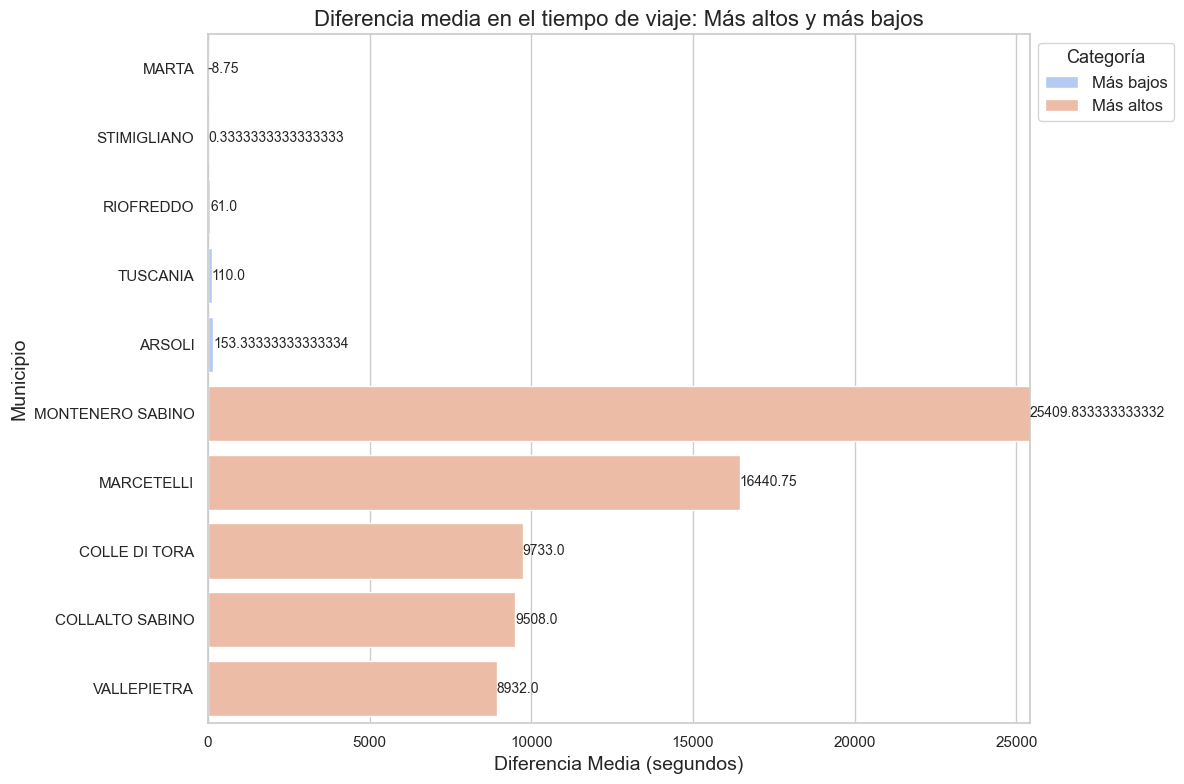

In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la media de las métricas relevantes agrupadas por municipio_name
def calcular_media_por_municipio(df, column_name):
    # Agrupar por municipio_name y calcular la media
    media = df.groupby("Comune")[[column_name]].mean().reset_index()
    # Renombrar la columna para claridad
    media.rename(columns={column_name: f"media_{column_name}"}, inplace=True)
    return media

# Función para obtener los 5 más altos, 5 más bajos y 5 más cercanos a cero
def obtener_top_bottom_zero(df, column_name):

    df_filtrato = df[df[column_name] != 0]

    # Los 5 más altos
    top_5 = df.nlargest(5, column_name)
    # Los 5 más bajos
    bottom_5 = df_filtrato.nsmallest(5, column_name)
    # Los 5 más cercanos a cero
    #closest_to_zero_5 = df.iloc[(df[column_name].abs()).argsort()[:5]]

    # Concatenar todos los resultados en el orden deseado
    result = pd.concat([bottom_5, top_5])
    result['categoria'] = ['Más bajos'] * len(bottom_5) + ['Más altos'] * len(top_5)

    return result

# Calcular para df_9AM y df_9PM
media = calcular_media_por_municipio(df, "diferencia")


# Obtener los 5 más altos, bajos y cercanos a 0
top_bottom_zero = obtener_top_bottom_zero(media, "media_diferencia")
print(top_bottom_zero)

# Configurar estilo para los gráficos
sns.set(style="whitegrid")

# Función para graficar las medias de diferencia por municipio
def plot_top_bottom_zero(media_df, column_name, titulo):
    # Crear el gráfico de barras
    plt.figure(figsize=(12, 8))  # Aumentar el tamaño para dar más espacio
    sns.barplot(
        x=column_name,
        y="Comune",
        data=media_df,
        hue="categoria",  # Colorear por categoría
        palette="coolwarm",  # Colores diferenciados para las categorías
        orient="h"
    )

    for index, value in enumerate(media_df["media_diferencia"]):
        plt.text(value, index, f"{value}", va="center", fontsize=10)

    # Añadir título y etiquetas
    plt.title(titulo, fontsize=16)
    plt.xlabel("Diferencia Media (segundos)", fontsize=14)
    plt.ylabel("Municipio", fontsize=14)

    # Ajustar la leyenda y moverla
    plt.legend(title='Categoría', title_fontsize='13', loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

    # Ajustar los límites del eje X si es necesario
    plt.xlim(media_df[column_name].min() - 10, media_df[column_name].max() + 10)  # Añadir un margen al eje X

    plt.tight_layout()
    #plt.xscale("log")
    plt.show()

# Graficar para 9AM y 9PM con separación de categorías
plot_top_bottom_zero(top_bottom_zero, "media_diferencia", "Diferencia media en el tiempo de viaje: Más altos y más bajos")

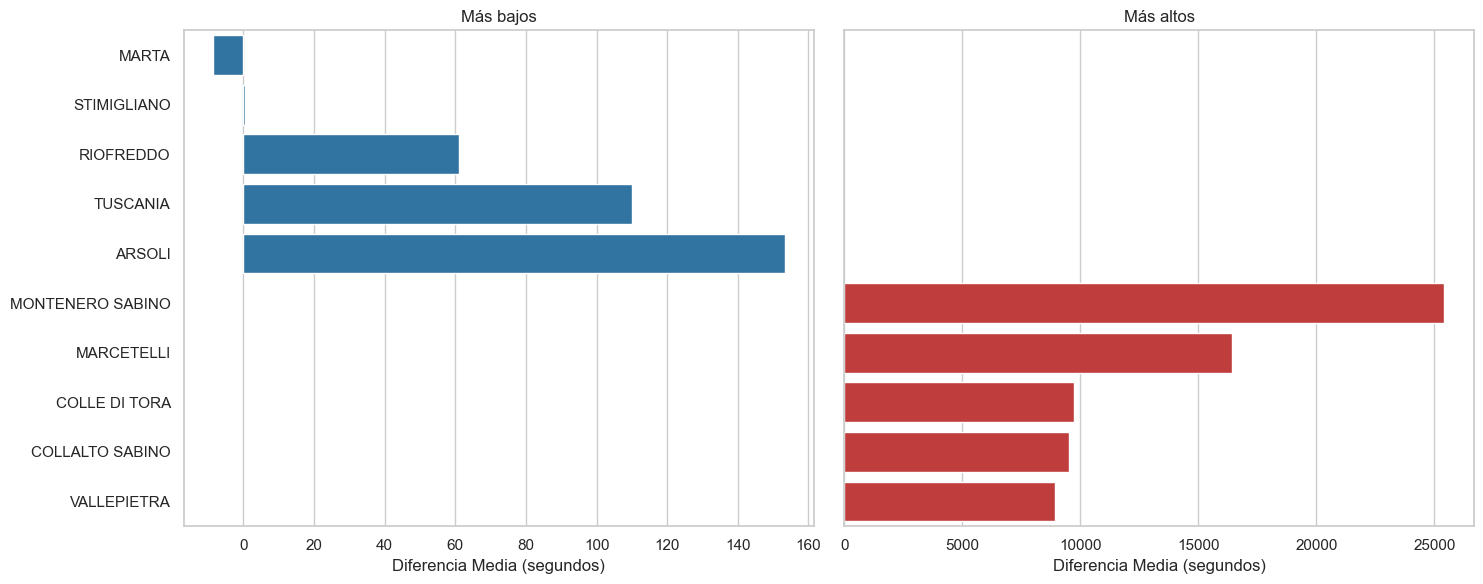

In [124]:
palette = {"Más bajos": "#1f77b4", "Más altos": "#d62728"}

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

for i, categoria in enumerate(["Más bajos", "Más altos"]):
    subset = top_bottom_zero[top_bottom_zero["categoria"] == categoria]
    sns.barplot(x="media_diferencia", y="Comune", data=subset, ax=axes[i], color=palette[categoria])
    axes[i].set_title(categoria)
    axes[i].set_xlabel("Diferencia Media (segundos)")
    axes[i].set_ylabel("")

plt.tight_layout()
plt.show()


### Diferencia por categoría de centro educativo (media)

C:\Users\vehico\AppData\Local\Temp\ipykernel_18188\2300116131.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


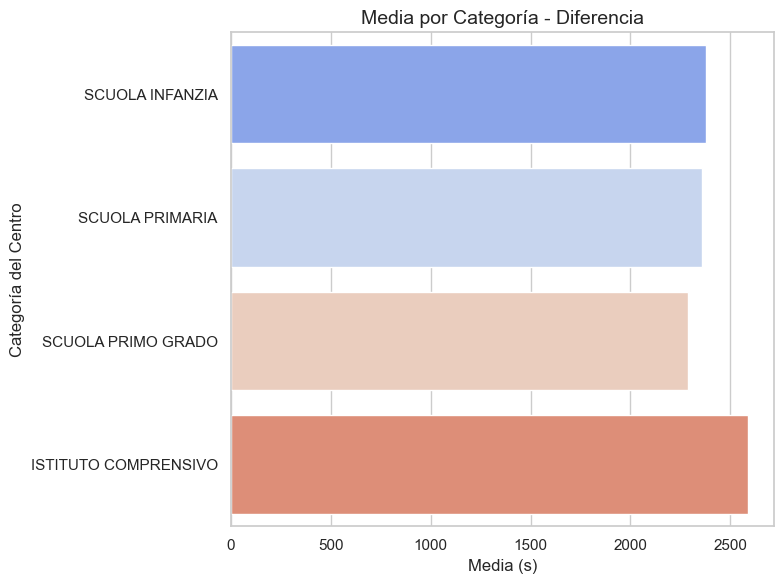

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la media de las métricas relevantes agrupadas por categoria_centro
def calcular_media_por_categoria(df, column_name):
    # Agrupar por categoria_centro y calcular la media
    media = df.groupby("Categoria_Scuola")[[column_name]].mean().reset_index()
    # Renombrar la columna para claridad
    media.rename(columns={column_name: f"media_{column_name}"}, inplace=True)
    return media

# Calcular para df_9AM y df_9PM
media_categoria = calcular_media_por_categoria(df, "diferencia")

# Función para graficar las medias de diferencia por categoría
def plot_media_por_categoria(media_df, column_name, titulo):
    # Ordenar por la columna media
    category_order = ['SCUOLA INFANZIA', 'SCUOLA PRIMARIA', 'SCUOLA PRIMO GRADO', 'ISTITUTO COMPRENSIVO']
    media_df = media_df.set_index("Categoria_Scuola").reindex(category_order).reset_index()

    # Crear el gráfico de barras
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x=column_name,
        y="Categoria_Scuola",
        data=media_df,
        palette="coolwarm",
        orient="h"
    )

    # Añadir título y etiquetas
    plt.title(titulo, fontsize=14)
    plt.xlabel("Media (s)", fontsize=12)
    plt.ylabel("Categoría del Centro", fontsize=12)
    plt.tight_layout()
    
    plt.show()

# Graficar para df_9AM y df_9PM
plot_media_por_categoria(media_categoria, "media_diferencia", "Media por Categoría - Diferencia")


### Diferencia por categoría de centro educativo (min y max)

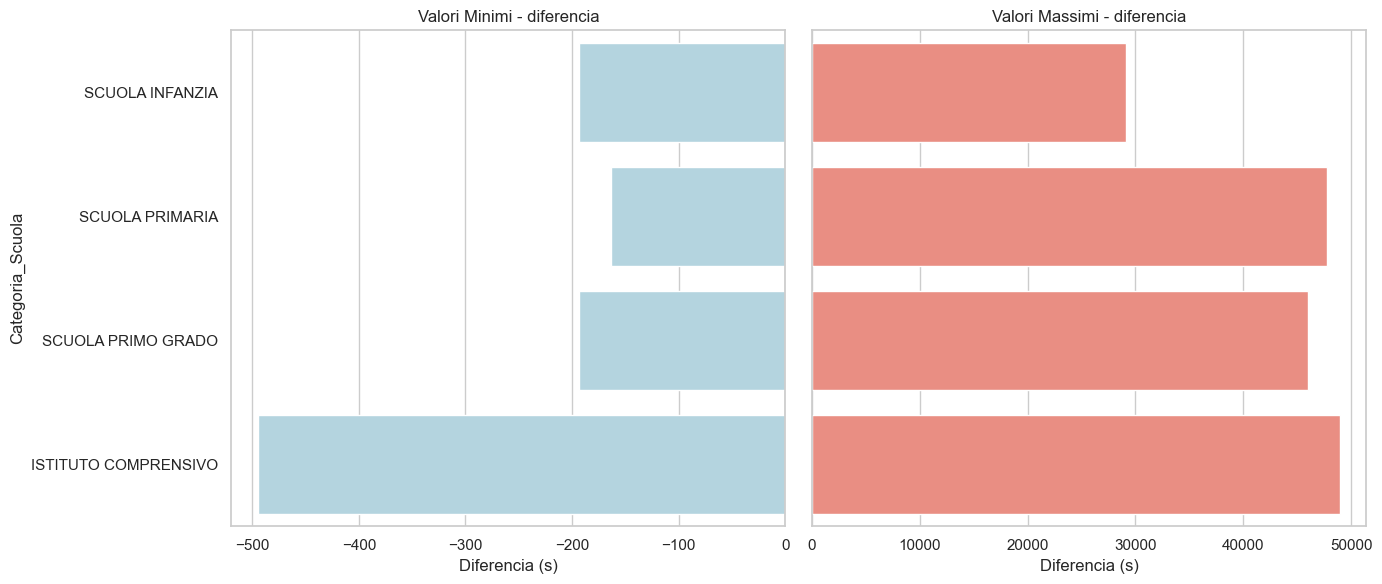

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

# Función para calcular el mínimo y el máximo de las métricas relevantes agrupadas por categoria_centro
def calcular_min_max_por_categoria(df, column_name):
    # Agrupar por categoria_centro y calcular el mínimo y máximo
    min_max = df.groupby("Categoria_Scuola")[[column_name]].agg(['min', 'max']).reset_index()
    # Renombrar las columnas para claridad
    min_max.columns = ["Categoria_Scuola", f"min_{column_name}", f"max_{column_name}"]
    return min_max

import seaborn as sns
import matplotlib.pyplot as plt

def plot_min_max_separati(min_max_df, column_name):
    category_order = ['SCUOLA INFANZIA', 'SCUOLA PRIMARIA', 'SCUOLA PRIMO GRADO', 'ISTITUTO COMPRENSIVO']
    min_max_df = min_max_df.set_index("Categoria_Scuola").reindex(category_order).reset_index()

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Grafico per i valori minimi
    sns.barplot(
        x=f"min_{column_name}",
        y="Categoria_Scuola",
        data=min_max_df,
        ax=axes[0],
        color="lightblue"
    )
    axes[0].set_title(f"Valori Minimi - {column_name}")
    axes[0].set_xlabel("Diferencia (s)")

    # Grafico per i valori massimi
    sns.barplot(
        x=f"max_{column_name}",
        y="Categoria_Scuola",
        data=min_max_df,
        ax=axes[1],
        color="salmon"
    )
    axes[1].set_title(f"Valori Massimi - {column_name}")
    axes[1].set_xlabel("Diferencia (s)")

    plt.tight_layout()
    plt.show()


min_max = calcular_min_max_por_categoria(df, "diferencia")

plot_min_max_separati(min_max, "diferencia")



# Distribuciónes de la distancias e de la diferencia de tiempo

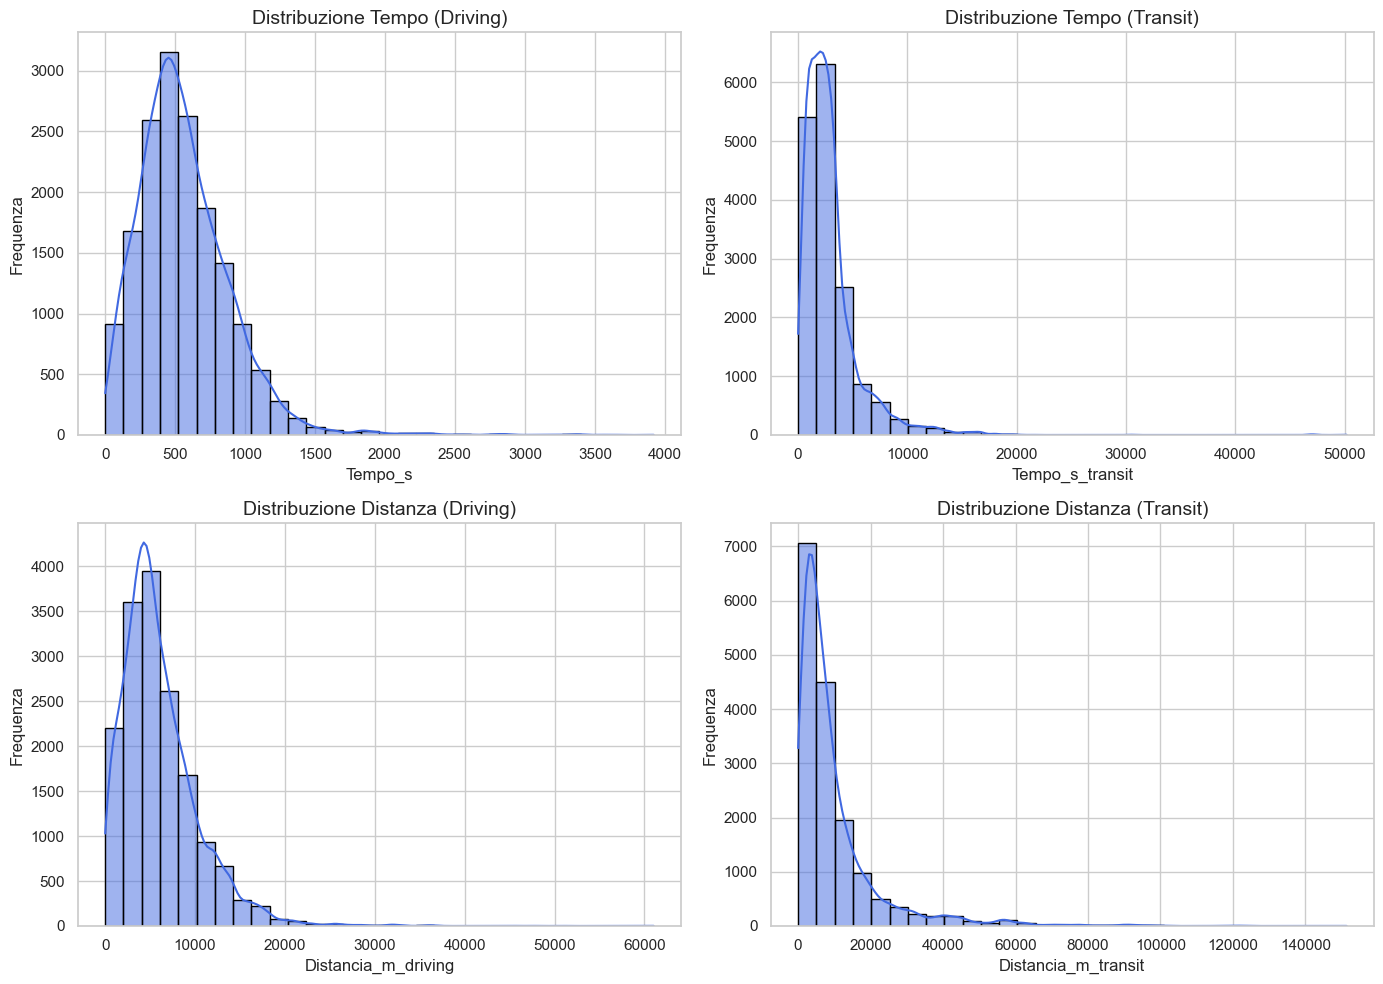

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurazione dello stile
sns.set(style="whitegrid")

# Lista delle colonne da visualizzare
columns = ["Tempo_s", "Tempo_s_transit", "Distancia_m_driving", "Distancia_m_transit"]
titles = [
    "Distribuzione Tempo (Driving)",
    "Distribuzione Tempo (Transit)",
    "Distribuzione Distanza (Driving)",
    "Distribuzione Distanza (Transit)"
]

# Creazione del grafico
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, col in enumerate(columns):
    ax = axes[i // 2, i % 2]
    
    # Histogramma + KDE plot per una migliore visualizzazione
    sns.histplot(df[col], bins=30, kde=True, ax=ax, color="royalblue", edgecolor="black")

    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Frequenza", fontsize=12)

plt.tight_layout()
plt.show()

Valor mínimo de la diferencia en tiempo: -495
Valor máximo de la diferencia en tiempo: 48949
Valor medio de la diferencia en tiempo: 2388.924859378821
Mediana de la diferencia en tiempo: 1850.0
Desviación estándar de la diferencia en tiempo: 2559.699525972166


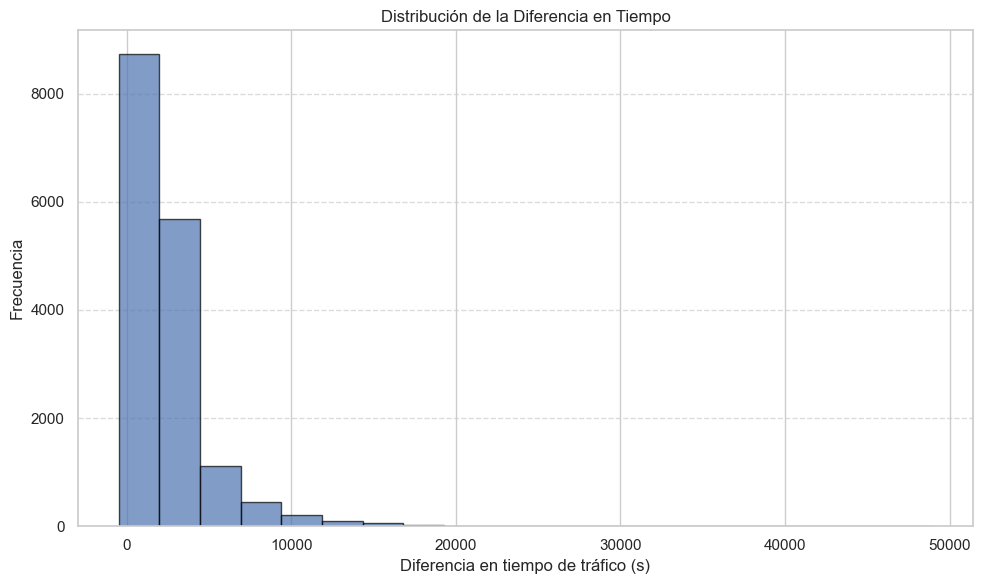

In [137]:
# Calcular el mínimo, máximo, media, mediana y desviación estándar de la diferencia en 'diferencia_trafico'
min_diferencia = df['diferencia'].min()
max_diferencia = df['diferencia'].max()
media_diferencia = df['diferencia'].mean()
mediana_diferencia = df['diferencia'].median()
desviacion_estandar_diferencia = df['diferencia'].std()

# Imprimir los resultados
print(f"Valor mínimo de la diferencia en tiempo: {min_diferencia}")
print(f"Valor máximo de la diferencia en tiempo: {max_diferencia}")
print(f"Valor medio de la diferencia en tiempo: {media_diferencia}")
print(f"Mediana de la diferencia en tiempo: {mediana_diferencia}")
print(f"Desviación estándar de la diferencia en tiempo: {desviacion_estandar_diferencia}")

# Graficar la distribución de la diferencia en tráfico utilizando un histograma
plt.figure(figsize=(10, 6))
plt.hist(df['diferencia'], bins=20, color='b', edgecolor='black', alpha=0.7)

# Añadir etiquetas y título
plt.title('Distribución de la Diferencia en Tiempo')
plt.xlabel('Diferencia en tiempo de tráfico (s)')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# distancias

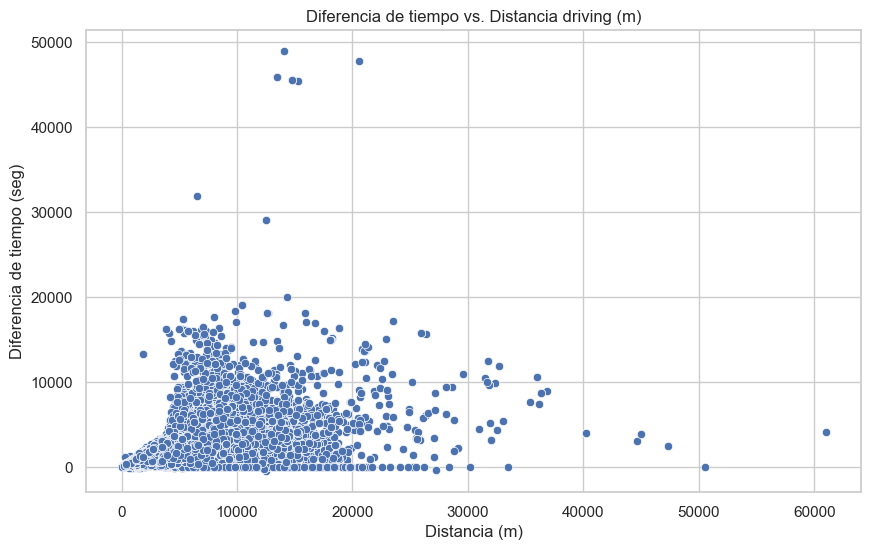

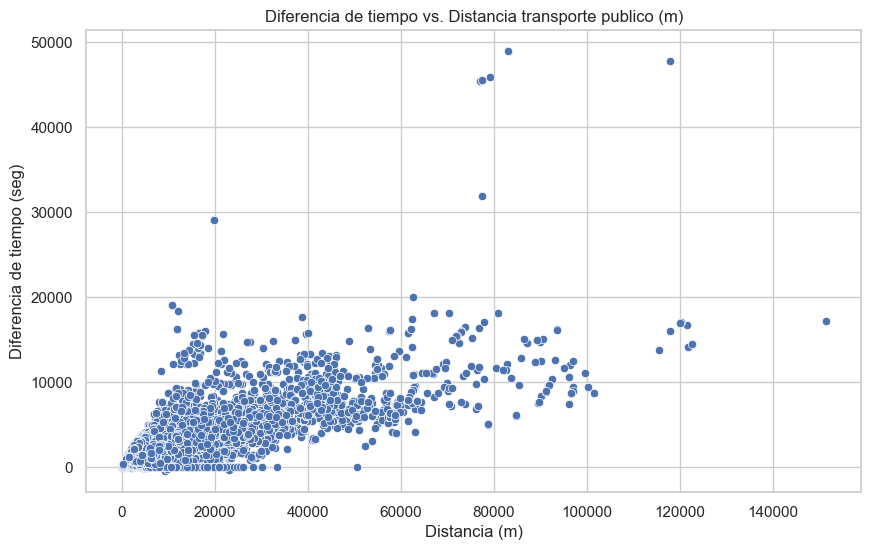

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

# Graficar la diferencia de tiempo en función de la distancia (ahora en km)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Distancia_m_driving', y='diferencia', data=df)
plt.title('Diferencia de tiempo vs. Distancia driving (m)')
plt.xlabel('Distancia (m)')
plt.ylabel('Diferencia de tiempo (seg)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Distancia_m_transit', y='diferencia', data=df)
plt.title('Diferencia de tiempo vs. Distancia transporte publico (m)')
plt.xlabel('Distancia (m)')
plt.ylabel('Diferencia de tiempo (seg)')
plt.grid(True)
plt.show()

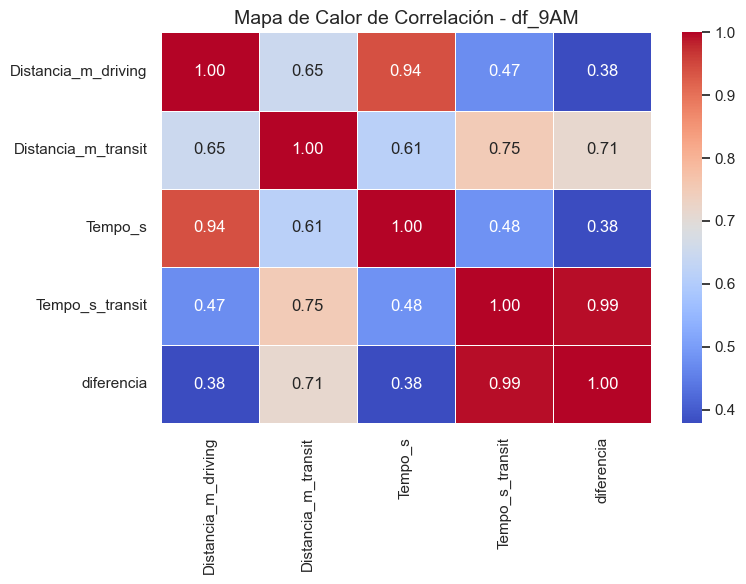

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar las columnas numéricas
df_numerico = df[['Distancia_m_driving', 'Distancia_m_transit', 'Tempo_s', 'Tempo_s_transit', 'diferencia']]

# Calcular la matriz de correlación
correlacion = df_numerico.corr()

# Graficar el mapa de calor de la correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True)

# Añadir título
plt.title('Mapa de Calor de Correlación - df', fontsize=14)
plt.tight_layout()
plt.show()


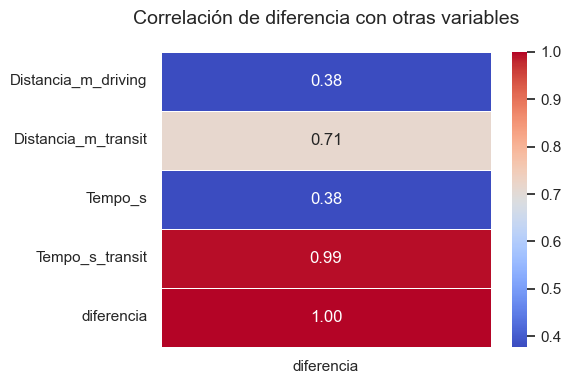

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar las columnas numéricas relevantes
df_numerico = df[['Distancia_m_driving', 'Distancia_m_transit', 'Tempo_s', 'Tempo_s_transit', 'diferencia']]

# Calcular la matriz de correlación
correlacion = df_numerico.corr()

# Extraer solo la correlación de "diferencia_9AM"
correlacion_diferencia_9AM = correlacion[['diferencia']]

# Graficar la correlación
plt.figure(figsize=(6, 4))
sns.heatmap(correlacion_diferencia_9AM, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True)

# Añadir título con espacio adicional
plt.title('Correlación de diferencia con otras variables', fontsize=14, pad=20)  # Aquí se ajusta el espacio

# Ajustar el diseño para evitar recortes
plt.tight_layout()

plt.show()


# más graficos

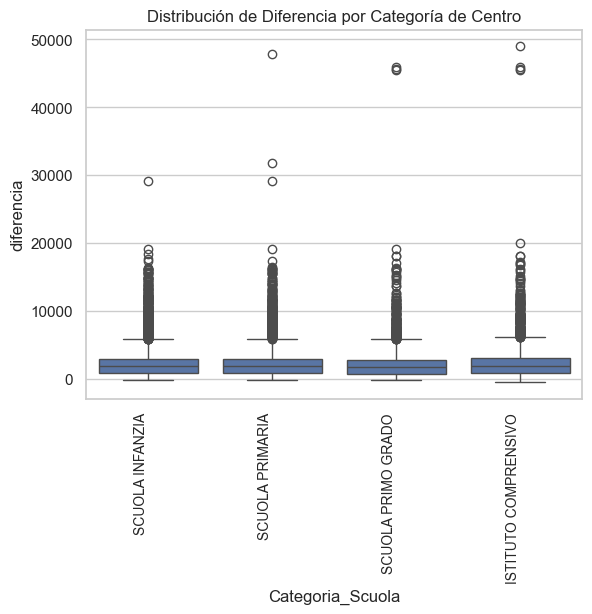

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Categoria_Scuola', y='diferencia', data=df)
plt.xticks(rotation=90, ha="right", fontsize=10)  
plt.title('Distribución de Diferencia por Categoría de Centro')
plt.show()


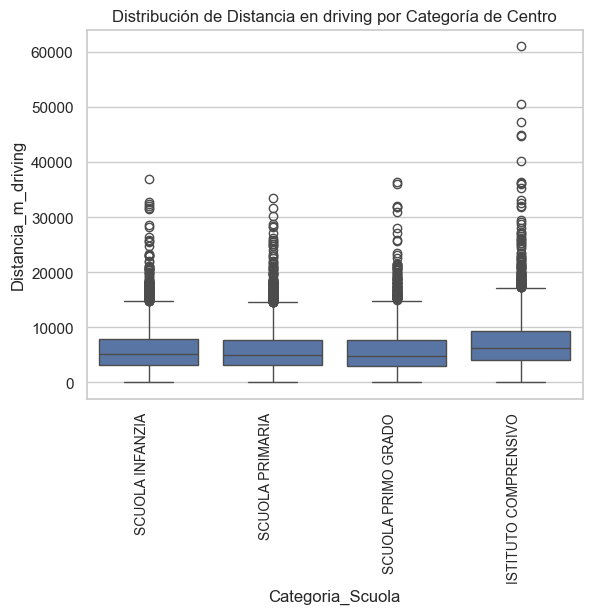

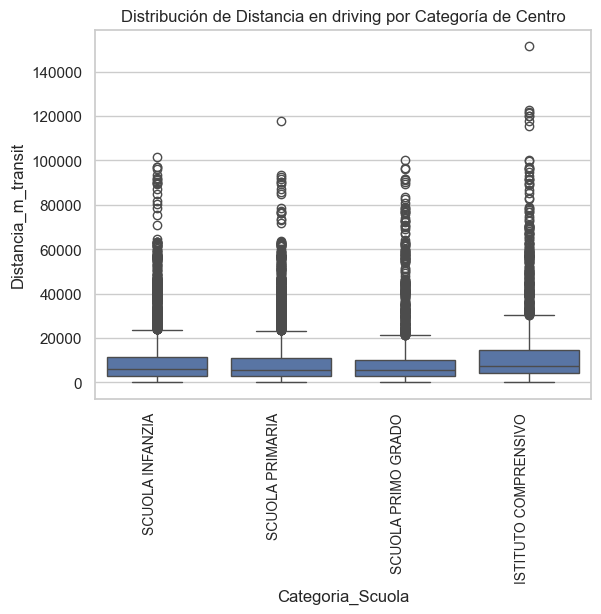

In [143]:
sns.boxplot(x='Categoria_Scuola', y='Distancia_m_driving', data=df)
plt.xticks(rotation=90, ha="right", fontsize=10)  
plt.title('Distribución de Distancia en driving por Categoría de Centro')
plt.show()

sns.boxplot(x='Categoria_Scuola', y='Distancia_m_transit', data=df)
plt.xticks(rotation=90, ha="right", fontsize=10)  
plt.title('Distribución de Distancia en driving por Categoría de Centro')
plt.show()